# Volatility 

Volatility can either be historical or implied; both are usually expressed on an annualized basis in percentage terms.

* Historical Volatility (HV) or Realized Volatility is the actual volatility demonstrated by the underlying over a period of time, such as the past month or year.
* Implied volatility (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.

## Challenges

Although the forecasting and modeling of volatility has been the focus of many empirical studies and theoretical investigations in academia, forecasting volatility accurately remains a crucial challenge for scholars. In addition, Crypto options trading is relatively new, there has not been too much research on the topic. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score 

%matplotlib inline

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


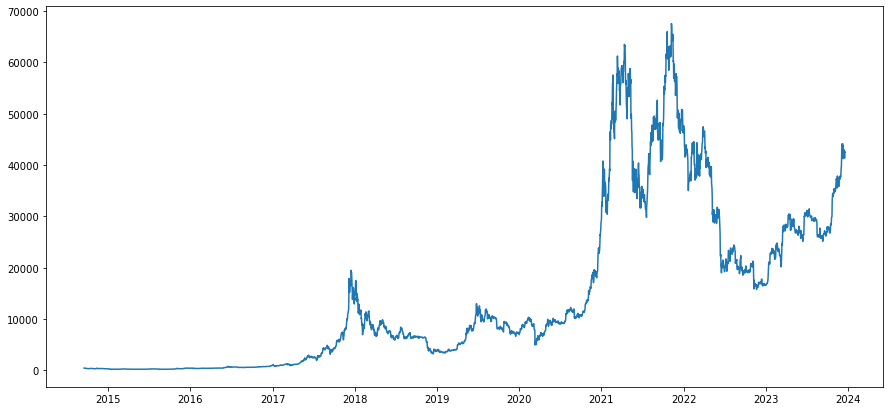

In [2]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
ticker_historical = ticker.history(start=start, 
                                   end=end, 
                                   interval="1d", proxy='http://10.0.5.8:30890')

plt.figure(figsize=(15,7))
plt.plot(ticker_historical.Close)
ticker_historical.head()

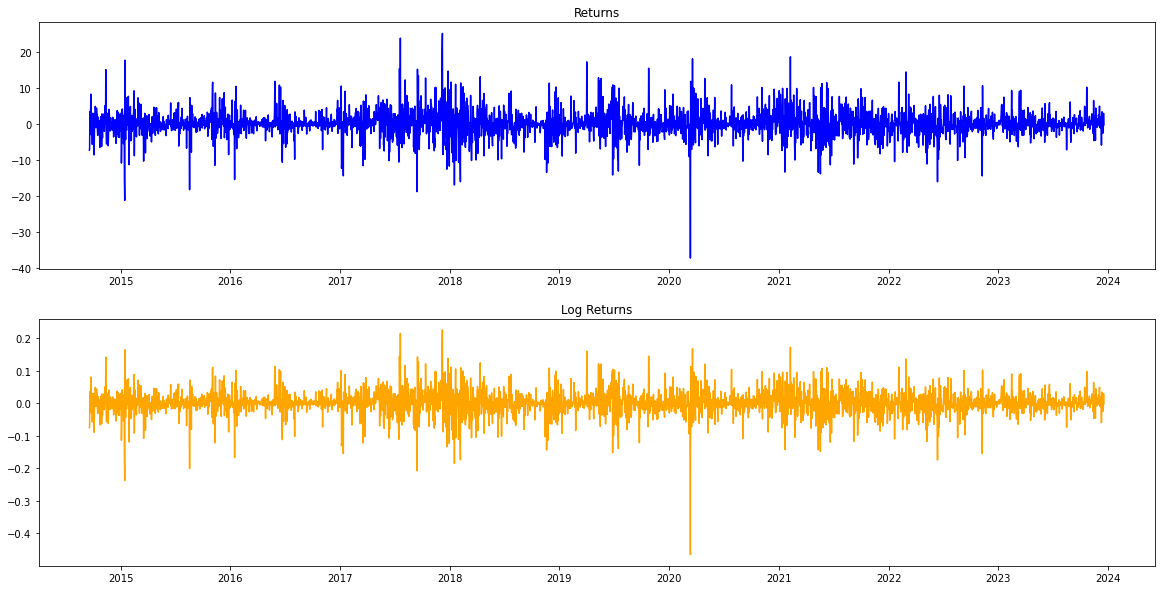

In [3]:

# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
returns = 100 * ticker_historical.Close.pct_change().dropna()
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
log_returns = np.log(ticker_historical.Close/ticker_historical.Close.shift(1)).dropna()


# VISUALIZE RETURNS VS. LOG RETURNS
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

ax1.plot(returns, color='blue')
ax1.set_title('Returns')

ax2.plot(log_returns, color='orange')
ax2.set_title('Log Returns')

fig.show()

/home/dev/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dev/miniconda3/envs/dev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


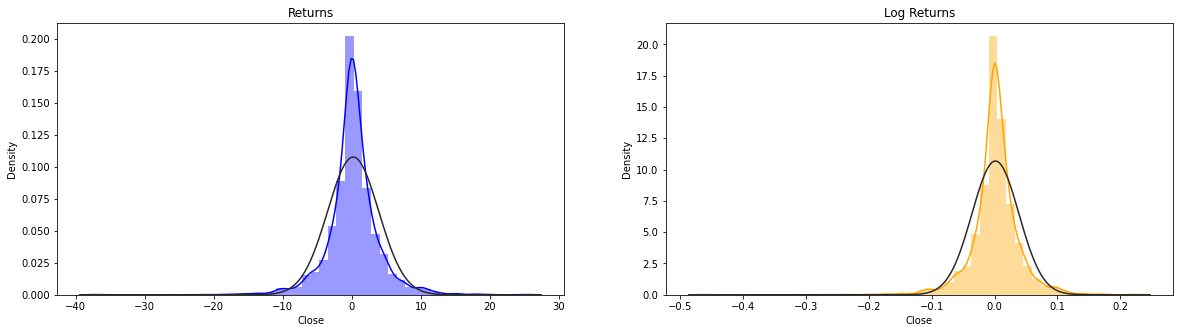

In [4]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.distplot(returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=ax1)
ax1.set_title('Returns')

sns.distplot(log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=ax2)
ax2.set_title('Log Returns')

fig.show()

For this specific project, the volatility would be calculated as the standard deviation of daily log returns, or the square root of the sum of squares of daily log returns:
$$\sigma_{t} = \sqrt{\sum_t{r^2_{t-1, t}}} $$

In [5]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
def realized_volatility(series_log_return):
    """
    Get realized volatility which is calculated as the square root
    of sum of squares of log returns
    """
    return np.sqrt(np.sum(series_log_return**2))

In [6]:
log_returns.apply(realized_volatility)

Date
2014-09-18 00:00:00+00:00    0.074643
2014-09-19 00:00:00+00:00    0.072402
2014-09-20 00:00:00+00:00    0.035111
2014-09-21 00:00:00+00:00    0.024968
2014-09-22 00:00:00+00:00    0.008317
                               ...   
2023-12-15 00:00:00+00:00    0.025762
2023-12-16 00:00:00+00:00    0.007375
2023-12-17 00:00:00+00:00    0.020943
2023-12-18 00:00:00+00:00    0.029980
2023-12-19 00:00:00+00:00    0.001725
Name: Close, Length: 3380, dtype: float64

In [8]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


adf_test(log_returns)

Results of Dickey-Fuller Test:
Test Statistic                -1.760325e+01
p-value                        3.911976e-30
#Lags Used                     9.000000e+00
Number of Observations Used    3.370000e+03
Critical Value (1%)           -3.432292e+00
Critical Value (5%)           -2.862398e+00
Critical Value (10%)          -2.567227e+00
dtype: float64


## Resources

* https://github.com/chibui191/bitcoin_volatility_forecasting/blob/main/Notebooks/Exploratory/book1.ipynb
* https://github.com/csatzky/forecasting-realized-volatility-using-supervised-learning